In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

In [54]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [56]:
def make_Dataset(x_train, x_val, y_train, y_val, batch_size=32):
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1)

    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1,1)

    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    return train_loader, x_val_tensor,y_val_tensor

In [57]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0

    model.train()
    for x,y in dataloader:
        x ,y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

In [58]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()

    with torch.no_grad():
        x, y= x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        eval_loss = loss_fn(pred,y).item()
    return eval_loss, pred

In [59]:
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list) + 1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker='.')
    plt.plot(epochs, val_loss_list, label='val_err', marker='.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [60]:
path='https://bit.ly/titanic_simple_csv'
data = pd.read_csv(path)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,7.2500,Southampton
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,71.2833,Cherbourg
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,7.9250,Southampton
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,53.1000,Southampton
4,5,0,3,"Allen, Mr. William Henry",male,35.0,8.0500,Southampton


In [61]:
target= 'Survived'
features = ['Sex', 'Age', 'Fare']
x = data.loc[:,features]
y = data.loc[:,target]

In [62]:
x = pd.get_dummies(x, columns=['Sex'], drop_first=True)
x.head()

,Age,Fare,Sex_male
0,22.0,7.2500,True
1,38.0,71.2833,False
2,26.0,7.9250,False
3,35.0,53.1000,False
4,35.0,8.0500,True


In [63]:
x_train, x_val, y_train, y_val = train_test_split(x,y,test_size=.3)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

y_train = y_train.values
y_val = y_val.values

In [64]:
train_loader, x_val_ts, y_val_ts = make_Dataset(x_train, x_val, y_train, y_val, 32)

for x,y in train_loader:
    print(f'Shape of x [rows, columns]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


In [65]:
n_feature = x.shape[1]

model = nn.Sequential(nn.Linear(n_feature,1),
                      nn.Sigmoid()
                      ).to(device)

In [66]:
loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.01)

In [67]:
epochs = 50
tr_loss_list, val_loss_list = [], []

for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)

    print(f'Epoch {t+1}, train loss: {tr_loss:.4f}, val loss: {val_loss:.4f}')

Epoch 1, train loss: 0.7393, val loss: 0.7123
Epoch 2, train loss: 0.6853, val loss: 0.6936
Epoch 3, train loss: 0.6561, val loss: 0.6853
Epoch 4, train loss: 0.6332, val loss: 0.6765
Epoch 5, train loss: 0.6275, val loss: 0.6690
Epoch 6, train loss: 0.6203, val loss: 0.6589
Epoch 7, train loss: 0.6072, val loss: 0.6481
Epoch 8, train loss: 0.5994, val loss: 0.6375
Epoch 9, train loss: 0.5924, val loss: 0.6267
Epoch 10, train loss: 0.5809, val loss: 0.6175
Epoch 11, train loss: 0.5719, val loss: 0.6076
Epoch 12, train loss: 0.5669, val loss: 0.6011
Epoch 13, train loss: 0.5648, val loss: 0.5950
Epoch 14, train loss: 0.5595, val loss: 0.5877
Epoch 15, train loss: 0.5544, val loss: 0.5810
Epoch 16, train loss: 0.5472, val loss: 0.5744
Epoch 17, train loss: 0.5420, val loss: 0.5689
Epoch 18, train loss: 0.5448, val loss: 0.5647
Epoch 19, train loss: 0.5384, val loss: 0.5586
Epoch 20, train loss: 0.5375, val loss: 0.5556
Epoch 21, train loss: 0.5311, val loss: 0.5503
Epoch 22, train loss: 

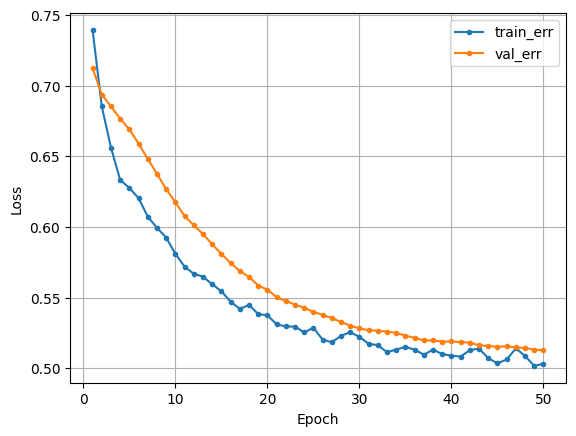

In [68]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [70]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)
print(pred.cpu().numpy()[:5])

[[0.19420014]
 [0.23180796]
 [0.67351663]
 [0.19609888]
 [0.18958007]]


In [71]:
pred = np.where(pred.cpu().numpy() > .5, 1,  0)
print(pred[:5])

[[0]
 [0]
 [1]
 [0]
 [0]]


In [72]:
print(confusion_matrix(y_val_ts.cpu().numpy(), pred))

[[93 20]
 [27 74]]


In [73]:
print(classification_report(y_val_ts.cpu().numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.78      0.82      0.80       113
         1.0       0.79      0.73      0.76       101

    accuracy                           0.78       214
   macro avg       0.78      0.78      0.78       214
weighted avg       0.78      0.78      0.78       214



In [ ]:
data = data.drop(['PassengerId', 'Name'], axis=1)

In [80]:
target = 'Survived'
x = data.drop(target, axis=1)
y = data.loc[:,target]

x = pd.get_dummies(x, columns= [ 'Pclass', 'Sex', 'Embarked'], drop_first=True)

In [81]:
x_train, x_val, y_train, y_val = train_test_split(x,y, test_size=.3)


scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

y_train = y_train.values
y_val = y_val.values

train_loader, x_val_ts, y_val_ts = make_Dataset(x_train,x_val, y_train, y_val, 32)

In [82]:
n_feature = x.shape[1]

model = nn.Sequential(nn.Linear(n_feature, 5),
                      nn.ReLU(),
                      nn.Linear(5,1),
                      nn.Sigmoid()
                      ).to(device)

loss_fn = nn.BCELoss()
optimizer = Adam(model.parameters(), lr=0.01)


In [83]:
epochs = 50
tr_loss_list, val_loss_list = [], []


for t in range(epochs):
    tr_loss = train(train_loader, model, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, tr loss:{tr_loss:.4f} val loss: {val_loss:.4f}')


Epoch 1, tr loss:0.6342 val loss: 0.6135
Epoch 2, tr loss:0.5890 val loss: 0.5683
Epoch 3, tr loss:0.5537 val loss: 0.5233
Epoch 4, tr loss:0.5211 val loss: 0.4946
Epoch 5, tr loss:0.5145 val loss: 0.4753
Epoch 6, tr loss:0.4936 val loss: 0.4635
Epoch 7, tr loss:0.4816 val loss: 0.4602
Epoch 8, tr loss:0.4848 val loss: 0.4494
Epoch 9, tr loss:0.4776 val loss: 0.4476
Epoch 10, tr loss:0.4784 val loss: 0.4449
Epoch 11, tr loss:0.4745 val loss: 0.4417
Epoch 12, tr loss:0.4747 val loss: 0.4397
Epoch 13, tr loss:0.4701 val loss: 0.4364
Epoch 14, tr loss:0.4728 val loss: 0.4332
Epoch 15, tr loss:0.4666 val loss: 0.4333
Epoch 16, tr loss:0.4644 val loss: 0.4275
Epoch 17, tr loss:0.4559 val loss: 0.4306
Epoch 18, tr loss:0.4671 val loss: 0.4243
Epoch 19, tr loss:0.4615 val loss: 0.4215
Epoch 20, tr loss:0.4560 val loss: 0.4282
Epoch 21, tr loss:0.4580 val loss: 0.4205
Epoch 22, tr loss:0.4457 val loss: 0.4225
Epoch 23, tr loss:0.4502 val loss: 0.4164
Epoch 24, tr loss:0.4483 val loss: 0.4196
E

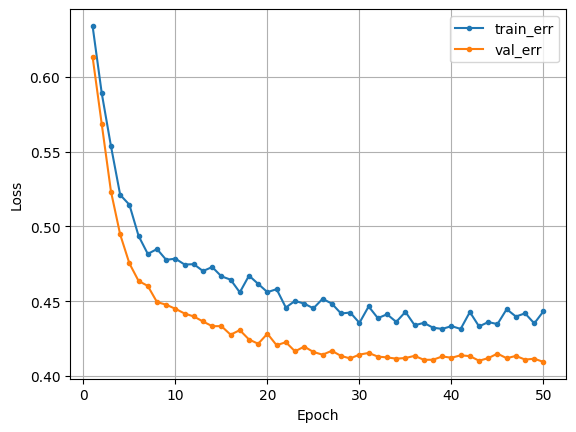

In [84]:
dl_learning_curve(tr_loss_list, val_loss_list)

In [87]:
_, pred = evaluate(x_val_ts, y_val_ts, model, loss_fn, device)

pred = np.where(pred.cpu().numpy() > .5, 1,0)

print(classification_report(y_val_ts.cpu().numpy(), pred))

              precision    recall  f1-score   support

         0.0       0.79      0.95      0.86       124
         1.0       0.91      0.64      0.75        90

    accuracy                           0.82       214
   macro avg       0.85      0.80      0.81       214
weighted avg       0.84      0.82      0.82       214

